# **Mounting Google Drive**

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Object Detection with XML Annotations**

**Importing and installing packages**

In [65]:
!pip install xmltodict

In [66]:
import os
import numpy as np
import xmltodict
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

**Loading the data**

In [67]:


def parse_voc_xml(xml_path):
    with open(xml_path) as fd:
        xml_dict = xmltodict.parse(fd.read())

    if 'annotation' in xml_dict and 'object' in xml_dict['annotation']:
        objects = xml_dict['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]  # Convert single object to list
    else:
        return None

    bboxes = []
    size = xml_dict['annotation']['size']
    width = int(size['width'])
    height = int(size['height'])

    for obj in objects:
        if isinstance(obj, dict) and 'bndbox' in obj:
            bbox = obj['bndbox']
            xmin = int(bbox['xmin']) / width
            ymin = int(bbox['ymin']) / height
            xmax = int(bbox['xmax']) / width
            ymax = int(bbox['ymax']) / height
            bboxes.append([xmin, ymin, xmax, ymax])
    return np.array(bboxes)

def load_data(img_dir, annot_dir, img_size=(128, 128)):
    images = []
    boxes = []
    img_filenames = sorted(os.listdir(img_dir))
    for img_filename in img_filenames:
        if img_filename.endswith('.png'):
            img_path = os.path.join(img_dir, img_filename)
            xml_path = os.path.join(annot_dir, img_filename.replace('.png', '.xml'))
            if os.path.exists(xml_path):
                img = load_img(img_path, target_size=img_size)
                img = img_to_array(img) / 255.0
                images.append(img)
                bboxes = parse_voc_xml(xml_path)
                if bboxes is not None and bboxes.size > 0:
                    boxes.append(bboxes[0])  # Use the first bounding box
                else:
                    boxes.append([0, 0, 0, 0])
            else:
                boxes.append([0, 0, 0, 0])
    return np.array(images), np.array(boxes)

img_dir = '/content/drive/MyDrive/images'
annot_dir = '/content/drive/MyDrive/annotations'
X, y = load_data(img_dir, annot_dir)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

**Training the model**

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

def create_object_detection_model(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),  # Increased dropout to reduce overfitting
        Dense(128, activation='relu'),
        Dense(4, activation='sigmoid')  # Output layer for bounding box coordinates
    ])

    optimizer = Adam(learning_rate=0.001)  # Lowered learning rate to stabilize training
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = create_object_detection_model()
model.summary()

# Introduce a learning rate reduction on plateau
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
    batch_size=32,  # You can adjust batch size if needed
    callbacks=[lr_reduction]
)

# Evaluate the model
loss = model.evaluate(X_valid, y_valid)
print(f"Validation Loss: {loss}")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)                   │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,549,444 (24.98 MB)

 Trainable params: 6,549,444 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - loss: 0.0534 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0355 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0299 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0318 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0231 - val_loss: 0.0337 - learning_rate: 0.0010
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0209 - val_loss: 0.0340 - learning_rate: 0.0010
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0189 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0152 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 9/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0120 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 10/30
22/22

**Visualisation of image with bounding box**

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


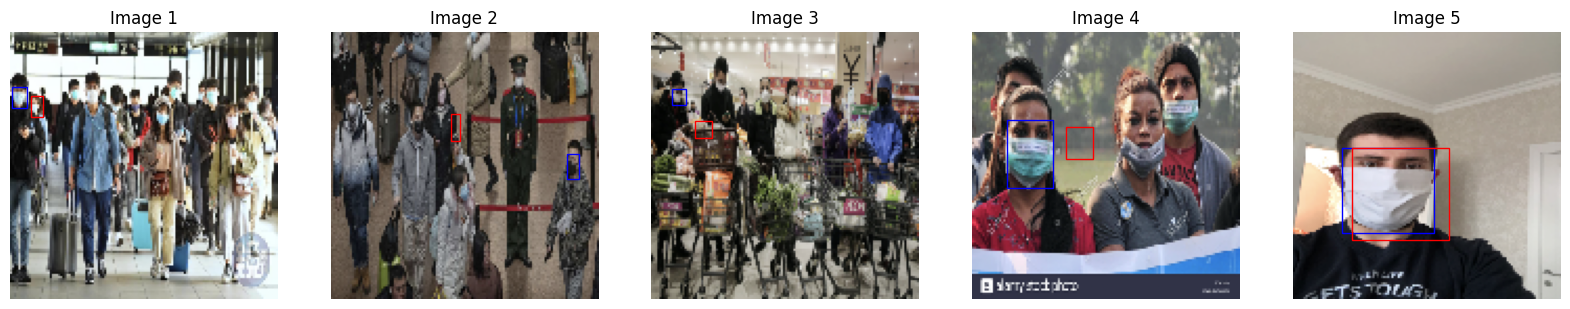

In [69]:
def visualize_predictions(X, y_true, y_pred, n_images=5, figsize=(15, 5)):
    plt.figure(figsize=figsize)  # Set the figure size
    for i in range(n_images):
        plt.subplot(1, n_images, i+1)
        plt.imshow(X[i])
        true_bbox = y_true[i]
        pred_bbox = y_pred[i]

        # Draw true bounding box
        plt.gca().add_patch(plt.Rectangle(
            (true_bbox[0]*X[i].shape[1], true_bbox[1]*X[i].shape[0]),
            (true_bbox[2]-true_bbox[0])*X[i].shape[1],
            (true_bbox[3]-true_bbox[1])*X[i].shape[0],
            fill=False, color='blue', label='True'
        ))

        # Draw predicted bounding box
        plt.gca().add_patch(plt.Rectangle(
            (pred_bbox[0]*X[i].shape[1], pred_bbox[1]*X[i].shape[0]),
            (pred_bbox[2]-pred_bbox[0])*X[i].shape[1],
            (pred_bbox[3]-pred_bbox[1])*X[i].shape[0],
            fill=False, color='red', label='Predicted'
        ))

        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Call the function with model predictions and enlarged image size
visualize_predictions(X_valid, y_valid, model.predict(X_valid), n_images=5, figsize=(20, 10))

# **VGG16-Based Object Detection Model**

In [73]:
def reshape_masks_to_bboxes(masks):
    bboxes = []
    for mask in masks:
        if mask.ndim == 3:
            mask = mask.squeeze()  # Remove channel dimension if present
        if mask.ndim == 2:
            rows = np.any(mask, axis=1)
            cols = np.any(mask, axis=0)

            if np.any(rows) and np.any(cols):
                rmin, rmax = np.where(rows)[0][[0, -1]]
                cmin, cmax = np.where(cols)[0][[0, -1]]
                bbox = [cmin/128, rmin/128, cmax/128, rmax/128]
            else:
                bbox = [0, 0, 0, 0]  # No object detected
        else:
            bbox = [0, 0, 0, 0]  # Handle unexpected mask shapes

        bboxes.append(bbox)
    return np.array(bboxes)

# Example usage
y_train_bboxes = reshape_masks_to_bboxes(y_train)
y_valid_bboxes = reshape_masks_to_bboxes(y_valid)

In [74]:
# Reshape y_train and y_valid
y_train_bboxes = reshape_masks_to_bboxes(y_train)
y_valid_bboxes = reshape_masks_to_bboxes(y_valid)

# Verify shapes
print("y_train_bboxes shape:", y_train_bboxes.shape)  # Should be (682, 4)
print("y_valid_bboxes shape:", y_valid_bboxes.shape)  # Should be (171, 4)

y_train_bboxes shape: (682, 4)
y_valid_bboxes shape: (171, 4)


In [76]:
from tensorflow.keras.optimizers import Adam

def create_vgg16_based_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(4, activation='sigmoid')(x)  # Adjust output layer as needed

    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),  # Use 'learning_rate' instead of 'lr'
                  loss='binary_crossentropy',  # Adjust loss function if necessary
                  metrics=['accuracy'])

    return model

# Create and summarize the model
model_vgg16 = create_vgg16_based_model()
model_vgg16.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 16,813,124 (64.14 MB)

 Trainable params: 2,098,436 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [77]:
# Create and compile the model
vgg16_model = create_vgg16_based_model()

# Train the model
vgg16_history = vgg16_model.fit(
    X_train, y_train_bboxes,
    validation_data=(X_valid, y_valid_bboxes),
    epochs=10,
    batch_size=32,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
               EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.5933 - loss: 0.3595 - val_accuracy: 0.6257 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6194 - loss: 0.0014 - val_accuracy: 0.3684 - val_loss: 3.2557e-04 - learning_rate: 1.0000e-04
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4200 - loss: 2.8146e-04 - val_accuracy: 0.2632 - val_loss: 1.3425e-04 - learning_rate: 1.0000e-04
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2387 - loss: 1.4112e-04 - val_accuracy: 0.1696 - val_loss: 8.0048e-05 - learning_rate: 1.0000e-04
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.1630 - loss: 9.4262e-05 - val_accuracy: 0.1404 - val_loss: 5.5751e-05 - learning_rate: 1.0000e-04
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.1263 - loss: 5.3263e-05 - val_accuracy: 0.1404 - val_loss: 4.1084e-05 - learning_rate: 1.0000e-04
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.0214 - loss: 0.8063
Validation Loss (VGG16-Based): [0.808357298374176, 0.02923976629972458]
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


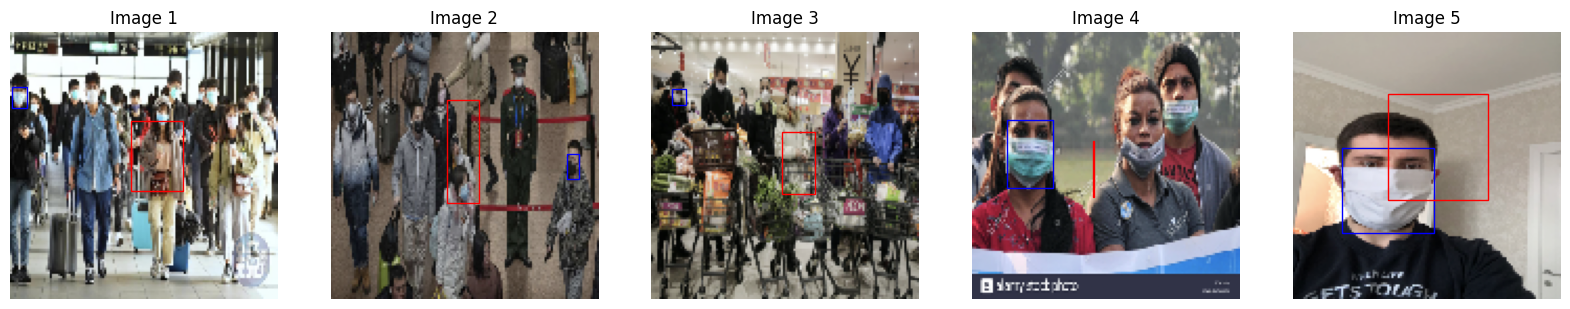

In [78]:
loss_vgg16 = model_vgg16.evaluate(X_valid, y_valid)
print(f"Validation Loss (VGG16-Based): {loss_vgg16}")

# Visualize VGG16-based predictions
visualize_predictions(X_valid, y_valid, model_vgg16.predict(X_valid), n_images=5, figsize=(20, 10))